# DCGAN

code reference : https://youtu.be/IZtv9s_Wx9I

paper : https://arxiv.org/abs/1511.06434


In [10]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import os

### 모델 특징
1. replace any pooling layers with strided convolutions(discriminator) and fractional-strided convolutions(generator) -> transpose_convolution
1. use batchnorm 
1. use ReLU activatiom in generator for all layers except or the output, which uses Tanh
1. use LeakyReLU activation in discriminator for all layers.

In [11]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2), # parameter => negative slope, negative_slope*x 으로 0이하 부분 계산
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),    
            self._block(features_d*4, features_d*8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2), # 3p, the slope of 
        )

    def forward(self, x):
        return self.disc(x)

In [12]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            # why use the convtranspose2d??
            # 설명 : https://cumulu-s.tistory.com/29
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),  # 왜 LeakyReLU 가 아니라 ReLU?     
        )

    def forward(self, x):
        return self.net(x)


In [13]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper 
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)): 
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [14]:
# 모델 돌아가는지 테스트 
def test():
    N, in_channels, H, W, = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn(N, noise_dim, 1, 1)
    print((N, in_channels, H, W))
    print(gen(z).shape)
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print('Success, tests passed!')

test()

(8, 3, 64, 64)
torch.Size([8, 3, 64, 64])
Success, tests passed!


### Train

In [15]:
# hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class config():
    lr = 2e-4
    batch_size = 128
    image_size = 64
    channels_img = 1
    noise_dim = 100
    num_epochs = 10
    features_disc = 64
    features_gen = 64
    dir_name = 'result'

config = config()

In [16]:
transforms = transforms.Compose(
    [
        transforms.Resize(config.image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(config.channels_img)], [0.5 for _ in range(config.channels_img)]
        ),
    ]
)

torch.Size([28, 28])


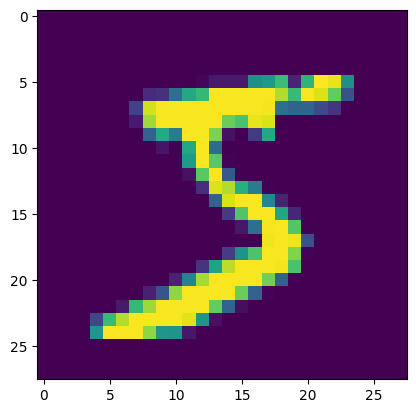

In [17]:
# MNIST dataset load
dataset = datasets.MNIST(
    root='dataset/', train=True, transform=transforms, download=True
)

plt.imshow(dataset.data[0]) # image check
print(dataset.data[0].shape)

In [18]:
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)
gen = Generator(config.noise_dim, config.channels_img, config.features_gen).to(device)
disc = Discriminator(config.channels_img, config.features_disc).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=config.lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=config.lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, config.noise_dim, 1, 1).to(device)
step = 0

In [19]:
print(gen.train())
print(disc.train())

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 1, 

In [20]:
for epoch in range(config.num_epochs):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(config.batch_size, config.noise_dim, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{config.num_epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                # writer_real.add_image("Real", img_grid_real, global_step=step)
                # writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
    if not os.path.exists(config.dir_name):
        os.makedirs(config.dir_name)
    samples = fake.reshape(config.batch_size, 1, 64, 64)
    save_image(samples, os.path.join(config.dir_name, f'DCGAN_fake_samples{epoch+1}.png'))

Epoch [0/10] Batch 0/469                   Loss D: 0.6940, loss G: 0.7647
Epoch [0/10] Batch 100/469                   Loss D: 0.0150, loss G: 4.0936
Epoch [0/10] Batch 200/469                   Loss D: 0.6629, loss G: 0.8252
Epoch [0/10] Batch 300/469                   Loss D: 0.4158, loss G: 1.6216
Epoch [0/10] Batch 400/469                   Loss D: 0.5182, loss G: 1.0569
Epoch [1/10] Batch 0/469                   Loss D: 0.6266, loss G: 0.5021
Epoch [1/10] Batch 100/469                   Loss D: 0.6346, loss G: 0.8607
Epoch [1/10] Batch 200/469                   Loss D: 0.6031, loss G: 0.9902
Epoch [1/10] Batch 300/469                   Loss D: 0.5816, loss G: 1.3982
Epoch [1/10] Batch 400/469                   Loss D: 0.6729, loss G: 1.9937
Epoch [2/10] Batch 0/469                   Loss D: 0.5467, loss G: 1.0795
Epoch [2/10] Batch 100/469                   Loss D: 0.5427, loss G: 1.3254
Epoch [2/10] Batch 200/469                   Loss D: 0.4988, loss G: 1.8719
Epoch [2/10] Batch